In [3]:
import sys
import json
import os
import pydicom
import datetime

import pandas as pd
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

import cv2

from tensorflow.keras.applications.inception_v3 import preprocess_input

In [4]:
def get_allocated_bits(img_path):
    img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    bits = int(np.where(img.dtype=='uint16', 16, 8))
    return bits

In [5]:
@tf.function
def crop_image_to_mask(img, mask,
    crop_shape=(299, 299),
    crop_masked_img=True, soft_mask=True):
    """Reads an image and a mask from disk using the provided read functions
    and returns a randomly selected image crop of the requested size that is centered around a
    segmented pixel.

    The mask is assumed to be scaled within the usual range for the provided dtype (e.g.
    0-255 for tf.uint8).

    Args:
        crop_shape: tuple(2). Requested crop size.
        crop_masked_img: boolean. If true, crops masked image rather than original.
        soft_mask: boolean. If true, the soft image mask is applied to the image,
            rather than a hard one.
    """
    mask = tf.convert_to_tensor(mask)
    mask /= 255
    mask_hard = tf.cast(tf.math.round(mask), dtype=img.dtype)

    if len(tf.shape(mask_hard)) < 3:
        mask_hard = tf.expand_dims(mask_hard, axis=-1)

    if crop_masked_img:
        if soft_mask:
            img_to_crop = tf.cast(tf.cast(img, tf.float32) * mask, img.dtype)
        else:
            img_to_crop = img * mask_hard
    else:
        img_to_crop = img

    crop_center_coords = select_random_segmented_pixel(mask_hard)
    cropped_img = centered_img_crop(img_to_crop, crop_center_coords, crop_shape)
    return cropped_img

@tf.function
def centered_img_crop(img, center_pixel_coords, crop_shape):
    """Extracts a crop from an image centered around the coordinates provided
    in center_pixel_coords.

    If the requested crop would extend beyond the edge of the image it will be constrained
    to fit inside.

    Args:
        img - image Tensor
        center_pixel_coords: tuple/list (height, width) with coordinates to center of crop
        crop_shape: tuple/list of (height, width) with dimensions of the crop to take

    Returns:
        img_crop: Tensor
    """

    center_pixel_coords = tf.cast(center_pixel_coords, tf.int32)
    crop_shape = tf.cast(crop_shape, tf.int32)

    min_val = tf.constant(0, dtype=tf.int32)
    two = tf.constant(2, dtype=tf.int32)

    offset_height = tf.math.maximum(center_pixel_coords[0] - crop_shape[0] // two, min_val)
    offset_height = tf.math.minimum(offset_height, tf.shape(img)[0] - crop_shape[0])
    offset_width = tf.math.maximum(center_pixel_coords[1] - crop_shape[1] // two, min_val)
    offset_width = tf.math.minimum(offset_width, tf.shape(img)[1] - crop_shape[1])

    img_crop = tf.image.crop_to_bounding_box(
        img, offset_height=offset_height, offset_width=offset_width,
        target_height=crop_shape[0], target_width=crop_shape[1])

    return img_crop

@tf.function
def select_random_segmented_pixel(mask):
    """Takes a binary mask and outputs the coordinates of a random positive point.

    Args:
        mask - 2D Tensor or 3D where one dimension is size 1.
        Assumes binary values [0, 1] where 1 denotes the candidates for sampling.
    """
    mask = tf.squeeze(mask)

    positive_segmentation_tensor = tf.ones(tf.shape(mask), dtype=mask.dtype)
    segmented_pixel_coords = tf.where(tf.equal(mask, positive_segmentation_tensor))

    random_coord_idx = tf.random.uniform([], maxval=tf.shape(segmented_pixel_coords)[0], dtype=tf.int32)
    random_segmented_coord = segmented_pixel_coords[random_coord_idx]
    return random_segmented_coord

In [6]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np

def read_dicom_uint8(path, target_size=(299, 299), preprocess_fn=None):
    image = tf.io.read_file(path)
    image = tfio.image.decode_dicom_image(image, color_dim=True,
                                          dtype=tf.uint8, scale='auto',
                                          on_error='lossy')
    image = tf.image.grayscale_to_rgb(image)
    image = tf.cast(image, tf.uint8)
    image = tf.image.resize(image, size=target_size)
    
    if preprocess_fn is not None:
        image = preprocess_fn(image)
    
    return image

def read_dicom_uint16(path, target_size=(299, 299), preprocess_fn=None):
    image = tf.io.read_file(path)
    image = tfio.image.decode_dicom_image(image, color_dim=True,
                                          dtype=tf.uint16, scale='auto',
                                          on_error='strict')[0]
    image = tf.image.grayscale_to_rgb(tf.cast(image, tf.int32))
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=target_size)
    
    if preprocess_fn is not None:
        image = preprocess_fn(image)
    
    return image

def preprocess_uint8_resnet(x):
    x = tf.cast(x, tf.float32)
    mean = [123.68, 116.779, 103.939]
    mean_tensor = tf.keras.backend.constant(-np.array(mean))
    x = tf.keras.backend.bias_add(x, mean_tensor, tf.keras.backend.image_data_format())
    return x

def preprocess_uint16_inception_input(x):
    x /= 32767.5
    x -= 1
    return x

def preprocess_arbitrary_inception_input(x):
    res = (2 * (x - np.min(x))/(np.max(x) - np.min(x))) - 1
    return res

In [7]:
def read_image(path, target_size=(299, 299), preprocess_fn=None):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3, dtype=dtype)
    image = image/np.max(image)
    image *= 255
    if target_size is not None:
        image = tf.image.resize(image, size=target_size)
    
    if preprocess_fn is not None:
        image = preprocess_fn(image)
    
    return image

In [8]:
def crop_dicom_to_mask(image, mask, preprocess_fn=None):
    x = crop_image_to_mask(image, mask,
                               crop_shape=(299, 299),
                               soft_mask=True, crop_masked_img=False)
    x = preprocess_fn(x)
    return x

In [19]:
#input_path = '/home/ignat/Downloads/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm'
input_path = '/root/mount/bravecx-covid/data/dicom_00000001_000.dcm'

In [20]:
IS_DICOM = False

if input_path.endswith('.dcm'):
    IS_DICOM = True

if IS_DICOM:
    object = pydicom.dcmread(fp=input_path, stop_before_pixels=True)
    print('Extracting DICOM metadata...')
    IMG_SHAPE = (object.Rows, object.Columns)

    BITS = object.BitsStored

    try:
        AGE = (datetime.datetime.strptime(object.StudyDate, '%Y%m%d') -
        datetime.datetime.strptime(object.PatientBirthDate, '%Y%m%d')).days/365.24
    except:
        print('WARNING: Age could not be determined from StudyDate tag')
        AGE = -1
else:
    print('WARNING: input is not in DICOM format')
    
    
    BITS = get_allocated_bits(input_path)
    if BITS == 16:
        dtype=tf.uint16
    else:
        dtype = tf.uint8
    object = read_image(input_path, target_size=None)
    IMG_SHAPE = object.shape
    AGE = -1

if (IMG_SHAPE[0] < 1500) | (IMG_SHAPE[1] < 1500):
    print('WARNING: image resolution is lower than 1500x1500. Interpret with caution!')

if BITS < 16:
    print('WARNING: BitsStored is under 16, falling back to 8-Bit inference. Interpret with caution!')

dicom_metadata = {'age': AGE,
               'rows': IMG_SHAPE[0],
               'columns': IMG_SHAPE[1],
               'bits_stored': BITS}

Extracting DICOM metadata...


In [22]:
print('Performing QC...')
body_part = tf.keras.models.load_model('../models/inceptionv3_299_299_other-chest', compile=False)
frontal_lateral = tf.keras.models.load_model('../models/inceptionv3_299_299_frontal_lateral', compile=False)
view_position = tf.keras.models.load_model('../models/inceptionv3_299_299_ap-pa', compile=False)

Performing QC...


In [26]:
if IS_DICOM:
    x = read_dicom_uint8(input_path, target_size=(299, 299), preprocess_fn=preprocess_input)
else:
    x = read_image(input_path, target_size=(299, 299), preprocess_fn=preprocess_input)
    x = tf.reshape(x, (1, 299, 299, 3))

proba_body_part = body_part.predict(x)
proba_frontal_lateral = frontal_lateral.predict(x)
proba_view_position = view_position.predict(x)

image_metadata = {'chest_xr_proba': proba_body_part[0].tolist()[1],
                  'frontal_xr_proba': proba_frontal_lateral[0].tolist()[0],
                  'ap_xr_proba': proba_view_position[0].tolist()[0]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


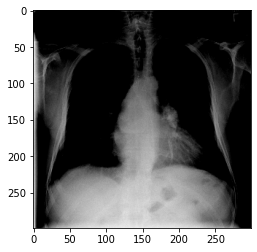

In [27]:
%matplotlib inline
plt.imshow(x.numpy().reshape(299, 299, 3))

In [30]:
image_metadata

{'chest_xr_proba': 1.0,
 'frontal_xr_proba': 1.0,
 'ap_xr_proba': 0.00010500976350158453}

In [31]:
print('Extracting lung segments')

cxr_segmentation = tf.keras.models.load_model('../models/resnet50_unet_segmentation_covix')
if IS_DICOM:
    x = read_dicom_uint8(input_path, target_size=(512, 512),
                        preprocess_fn=preprocess_uint8_resnet)
else:
    x = read_image(input_path, target_size=(512, 512),
                   preprocess_fn=preprocess_uint8_resnet)
    x = tf.reshape(x, (1, 512, 512, 3))

proba = cxr_segmentation.predict(x)
proba = proba.reshape((256, 256, 2)).argmax(axis=2)
MASK = np.stack((proba,)*3, axis=-1)
MASK = tf.image.resize(MASK, size=(IMG_SHAPE[0], IMG_SHAPE[1]), method='nearest').numpy() * 255

Extracting lung segments


In [32]:
if IS_DICOM:
    img = pydicom.read_file(input_path)
    img = img.pixel_array
else:
    img = plt.imread(input_path)

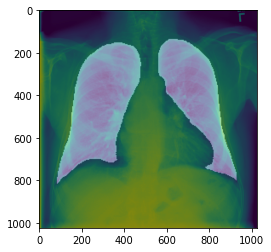

In [36]:
plt.imshow(img)
plt.imshow(MASK, alpha=0.4)

In [37]:
mask_model = tf.keras.models.load_model('../models/inceptionv3_masks_299_299_diagnosis', compile=False)

if IS_DICOM:
    cxr = read_dicom_uint16(input_path, target_size=(1500, 1500))
    cxr = tf.reshape(cxr, (1500, 1500, 3))
    x = np.array([crop_dicom_to_mask(cxr, MASK, preprocess_uint16_inception_input) for i in range(50)])
else:
    cxr = read_image(input_path, target_size=(1500, 1500))
    x = np.array([crop_dicom_to_mask(cxr, MASK, preprocess_input) for i in range(50)])


mask_proba = np.mean(mask_model.predict(x), axis=0)

In [38]:
mask_proba

array([6.1363506e-05, 1.9050867e-03, 9.6943444e-01, 2.8599264e-02],
      dtype=float32)